## Notes on ```ali_offiline_demod.py```

#### This notebook will serve as place to have each function and then work out/write down what is happening in text form so as to be able to refer and also write down questions. 

In [1]:
import numpy as np
import matplotlib as mpl
#mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import scipy

from scipy.signal import sawtooth, square, savgol_filter
import pandas as pd
import glob as gl
import os
import cmath

from scipy.signal import sawtooth, square,find_peaks
from scipy import spatial
#import lambdafit as lf
from scipy.interpolate import CubicSpline,interp1d
import h5py

from tqdm import tqdm as tqdm_terminal
from tqdm.notebook import trange, tqdm_notebook
from scipy.signal.windows import hann

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit

#### Will be working backwards to understand all functions embedded within ```full_demod_process```:

In [2]:
def full_demod_process(ts_file, f_sawtooth, method = 'fft', correct_phase_jumps = False, phase_jump_threshold = 0.4, n=0, channels='all',start_channel=0,stop_channel=1000,tone_init_path = '/home/matt/alicpt_data/tone_initializations', ts_path = '/home/matt/alicpt_data/time_streams', display_mode = 'terminal'):
    #n is number of points blanked before and after fr reset; only used when method='simple'
    #unpack data -> eventually change so that you give the ts data path and the function finds the associated tone initialization files

    print('using full_demod_process')

    init_freq = ts_file.split('_')[3]
    print(init_freq)
    init_time = ts_file.split('_')[4]
    print(init_time)
    init_directory = f'{tone_init_path}/fcenter_{init_freq}_{init_time}/'
    print(init_directory)
    
    initial_lo_sweep_path = find_file(init_directory, 'lo_sweep_initial')
    targeted_lo_sweep_path = find_file(init_directory, 'lo_sweep_targeted_2')
    tone_freqs_path = find_file(init_directory, 'freq_list_lo_sweep_targeted_1')
    ts_path = f'{ts_path}/{ts_file}'    
    
    initial_lo_sweep=np.load(initial_lo_sweep_path) #find initial lo sweep file
    targeted_lo_sweep=np.load(targeted_lo_sweep_path) #find targeted sweep file
    tone_freqs=np.load(tone_freqs_path) #find tone freqs
    #print(tone_freqs)
    if channels == 'some':
        tone_freqs = tone_freqs[start_channel + 23:stop_channel + 23 + 1]
        print(tone_freqs)
    ts_fr,Is_fr,Qs_fr=read_data(ts_path,channels=channels,start_channel=start_channel,stop_channel=stop_channel)    #note to self: limit tone_freqs to actively called channels; need to figure out channel numbering first
    
    #testing fixing the time breaks before the demod -- probably don't want to keep this but we'll see
    fs=512e6/(2**20)    #this line is incredibly important; need to make sure we match the data rate at all times; add an if statement for faster data rate data
    #fs=256e6/(2**19)
    ts_fr = np.arange(Is_fr.shape[1])/fs
    
    
    print(f'num of channels: {len(Is_fr)}')
    print(f'num of tones: {len(tone_freqs)}')
    
    """
    #depricated code for finding delay region
    #look at initial sweep
    plot_s21([initial_lo_sweep])
    
    
    #choose delay region - should automate finding an area without peaks later
    delay_region_start = float(input('Delay Region Start (GHz): '))*1e9
    delay_region_stop = float(input('Delay Region Stop (GHz): '))*1e9
    """
    #compute delay region
    print('looking for delay region')
    delay_region_start, delay_region_stop = find_freqs_cable_delay_subtraction(initial_lo_sweep,0.98,10000)
    print(f'start = {delay_region_start}')
    print(f'stop = {delay_region_stop}')
    
    #measure cable delay
    delays = measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=False)
    
    print(f'delay: {np.median(delays)}')

    #remove cable delay
    targeted_lo_sweep_rm=remove_delay(targeted_lo_sweep,
                                      np.median(delays),
                                      channels=channels,
                                      start_channel=start_channel,
                                      stop_channel=stop_channel)
    
    IQ_stream_rm=remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,np.median(delays))
    
    #measure circle parameters
    calibration=measure_circle_allch(targeted_lo_sweep_rm,
                                     tone_freqs,
                                     channels=channels,
                                     start_channel=start_channel,
                                     stop_channel=stop_channel) #finds circle center and initial phase for every channel
    
    print(calibration[0])
    #calibrate time stream
    data_cal=get_phase(IQ_stream_rm,calibration)

    #fig_testing, ax_testing = plt.subplots(1)
    #for i in [1]:
    #    ax_testing.plot(data_cal[i])
    
    #find nphi_0
    t_start=0
    t_stop=10

    n_phi0 = find_n_phi0(ts_fr[488*t_start:488*t_stop],data_cal[:,488*t_start:488*t_stop],f_sawtooth,plot=False)  #discard the first few seconds
    print(f'n_phi0: {n_phi0}')
    
    #find t0
    t0_array = np.array([])
    for current_channel in range(len(data_cal)):
        t0 = mea_reset_t0(ts_fr[488*t_start:488*t_stop],data_cal[current_channel,488*t_start:488*t_stop],f_sawtooth,plot=False)
        #ts_freq = 1/np.nanmedian(np.diff(ts_fr))
        #t0 = mea_reset_t0(ts_fr[ts_freq*t_start:ts_freq*t_stop],data_cal[current_channel,ts_freq*t_start:ts_freq*t_stop],f_sawtooth,plot=False)
        t0_array = np.append(t0_array,t0)

    t0_med = np.nanmedian(t0_array)
    
    #demod
    
    if method == 'simple' or method =='iv':
        t_demods=[]
        data_demods=[]
    elif method == 'fft':
        t_demods=np.array([])
        data_demods=np.array([])
        ch_count = 0
    start_idx = find_nearest_idx(ts_fr-ts_fr[0], t0_med)
    print(f'start index: {start_idx}')
    if display_mode == 'notebook':
        for chan in tqdm_notebook(range(data_cal.shape[0])):#np.arange(225,230,1):#range(data_cal.shape[0]):
            if method == 'iv':
                t_demod, data_demod = demodulate_for_iv(ts_fr[start_idx:]-ts_fr[start_idx], data_cal[chan, start_idx:], n_phi0, 3,f_sawtooth)
            
                t_demods.append(t_demod)
                data_demod_unwrap=np.unwrap(data_demod,period=1)
                data_demods.append(data_demod_unwrap)
            if method == 'simple':
                t_demod, data_demod, reset_indices = demodulate(ts_fr[start_idx:]-ts_fr[start_idx],
                                                                data_cal[chan, start_idx:],
                                                                n_phi0,
                                                                n,
                                                                f_sawtooth)
                t_demods.append(t_demod)
                data_demod_unwrap=np.unwrap(data_demod,period=1)
                data_demods.append(data_demod_unwrap)
            if method == 'fft':
                t_demod, data_demod, reset_indices = demodulate_with_fft(t=ts_fr,
                                                                        sig=data_cal[chan],
                                                                        start_index=start_idx,                                                                      
                                                                        f_fr=f_sawtooth,
                                                                        phase_units='nPhi0',
                                                                        correct_phase_jumps=correct_phase_jumps,
                                                                        phase_jump_threshold=phase_jump_threshold,
                                                                        plot_demod = False,
                                                                        plot_demod_title=None,
                                                                        intermediate_plotting_limits=[None,None],
                                                                        plot_chunking_process = False,
                                                                        plot_fft = False,
                                                                        plot_fft_no_dc = False,
                                                                        plot_limited_fft = False,
                                                                        plot_fit = False,
                                                                        plot_vectors = False)
                
                #print(t_demod)
                if ch_count == 0:
                    data_demods = data_demod
                else:
                    #t_demods = np.append(t_demods, np.array(t_demod))
                    data_demods = np.vstack([data_demods, np.array(data_demod)])
                t_demods = t_demod
                ch_count += 1
    elif display_mode == 'terminal':
        
        for chan in tqdm_terminal(range(data_cal.shape[0])):#np.arange(225,230,1):#range(data_cal.shape[0]):
            if method == 'simple':
                t_demod, data_demod, reset_indices = demodulate(ts_fr[start_idx:]-ts_fr[start_idx],
                                                                data_cal[chan, start_idx:],
                                                                n_phi0,
                                                                n,
                                                                f_sawtooth)
                t_demods.append(t_demod)
                data_demod_unwrap=np.unwrap(data_demod,period=1)
                data_demods.append(data_demod_unwrap)
            if method == 'fft':
                t_demod, data_demod, reset_indices = demodulate_with_fft(t=ts_fr,
                                                                        sig=data_cal[chan],
                                                                        start_index=start_idx,                                                                      
                                                                        f_fr=f_sawtooth,
                                                                        phase_units='nPhi0',
                                                                        correct_phase_jumps=False,
                                                                        phase_jump_threshold=0,
                                                                        plot_demod = False,
                                                                        plot_demod_title=None,
                                                                        intermediate_plotting_limits=[None,None],
                                                                        plot_chunking_process = False,
                                                                        plot_fft = False,
                                                                        plot_fft_no_dc = False,
                                                                        plot_limited_fft = False,
                                                                        plot_fit = False,
                                                                        plot_vectors = False)
                
                #print(t_demod)
                if ch_count == 0:
                    data_demods = data_demod
                else:
                    #t_demods = np.append(t_demods, np.array(t_demod))
                    data_demods = np.vstack([data_demods, np.array(data_demod)])
                t_demods = t_demod
                ch_count += 1
    

    data_demods=np.vstack(data_demods)
    if method == 'simple':
        t_demods=np.vstack(t_demods)
    
        data_dict = {'fr t': ts_fr, 
                    'fr data': data_cal, 
                    'nphi': n_phi0, 
                    't0': t0_med,
                    'start index': start_idx,
                    'demod t': t_demods[1], 
                    'demod data': data_demods, 
                    'channel freqs': tone_freqs, 
                    'fsawtooth': f_sawtooth,
                    'reset indices': reset_indices}
    elif method == 'fft':
        data_dict = {'fr t': ts_fr, 
                    'fr data': data_cal, 
                    'nphi': n_phi0, 
                    't0': t0_med,
                    'start index': start_idx,
                    'demod t': t_demods, 
                    'demod data': data_demods, 
                    'channel freqs': tone_freqs, 
                    'fsawtooth': f_sawtooth,
                    'reset indices': reset_indices,
                    'raw i':Is_fr,
                    'raw q':Qs_fr}

    return data_dict

#### FILES BEING USED: 
1. Timestream file 
2. LO Sweep Initial 
3. LO Sweep Targeted 
4. Frequency List Targeted

- is initial frequency list used too? 
- SWEEP DIMENSIONS: (2, 1000, 500)
    - there are two blocks. 
    - Block 1 = frequencies
    - Block 2 = $S_{21}$

In [3]:
# defining using LO 4250 chopped data for purposes of function defining and note-taking
ts_file = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/time_streams/ts_toneinit_fcenter_4250.0_20240216162215_t_20240216163432.hd5'
tone_init_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_inits'
#ts_path = 'Users/leayamashiro/AliCPT/alicpt_data/chopped_data/time_streams'

#### Starting out, arguments: 

```ts_file```: file path of data

```f_sawtooth```: rate of data taking, usually **15 hz** -- flux ramp rate? 

```method```: default method is ```'fft'```, other options are ```'simple'``` and ```'iv'```, dictates different demodulation methods defined as functions (to be discussed)

```correct_phase_jumps```: default is ```False```. There’s this problem in the system where it’s dropping data packets every once in a while instead of continuously and uniformly, and this can try to correct for that by breaking them up. May or may not be necessary in future. 

```phase_jump_threshold```: if ```correct_phase_jumps == True```, determines numerical break-up threshold, default 0.4 (units?)

```n```: number of points blanked before and after fr reset; only used when method='simple'

```channels```: default is ```'all'``` 

```start_channel``` & ```stop_channel```: default (0, 1000), self explanatory, will integrate new chunking methods? 

```tone_init_path```: streamlines tone initialization directory retrival

```ts_path```: streamlines time stream data directory retrieval 

```display_mode```: default = ```'terminal'``` – just has to do with the way that progress bars are projected in terminal vs. jupyter notebook (```'notebook'```)

#### **First Segment** 

1. Just defining paths for time stream data, tone initialization files. 

In [4]:
# init_freq = ts_file.split('_')[3]
# print(init_freq)
# init_time = ts_file.split('_')[4]
# print(init_time)
# init_directory = f'{tone_init_path}/fcenter_{init_freq}_{init_time}/'
# print(init_directory)

# initial_lo_sweep_path = find_file(init_directory, 'lo_sweep_initial')
# targeted_lo_sweep_path = find_file(init_directory, 'lo_sweep_targeted_2')
# tone_freqs_path = find_file(init_directory, 'freq_list_lo_sweep_targeted_1')
# ts_path = ts_file
#ts_path = f'{ts_path}/{ts_file}' 

# okay not going to work right now with the setup not the same but understanding how everything is laid out here

In [5]:
def find_file(p,filetype):
    #filetype could be target,eta,freqs,test,ALICPT_RDF
    if filetype=='target':
        filenames=filename=gl.glob(p+'%s_*'%filetype)
        filename = max(filenames, key=os.path.getctime)
    else:
        filename=gl.glob(p+'%s_*'%filetype)[0]
    return filename

Using ```glob``` package to compress and organize file name strings. OS stuff: 

```(function) def getctime(filename: FileDescriptorOrPath) -> float```

Ask more later about specific functions in the naming/directories up here^^

In [6]:
# read data function, using matt's for now: 

def read_data(filename,channels='all',start_channel=0,stop_channel=1000):
    if channels == 'all':
        file = h5py.File(filename, 'r')
        adc_i = np.array(file['time_ordered_data']['adc_i'])
        adc_i = np.delete(adc_i, slice(0,22), 0)
        adc_q = file['time_ordered_data']['adc_q']
        adc_q = np.delete(adc_q, slice(0,22), 0)
        t = np.array(file['time_ordered_data']['timestamp'])  
    elif channels == 'some':
        start_channel += 23 #eliminate the first 23 empty channels in hdf5 -> makes channel numbering match resonator numbering
        stop_channel += 23 + 1 #eliminate the first 23 empty channels in hdf5 -> makes channel numbering match resonator numbering; +1 forces python to include the stop_channel
        file = h5py.File(filename, 'r')
        adc_i = np.array(file['time_ordered_data']['adc_i'][start_channel:stop_channel]) 
        adc_q = np.array(file['time_ordered_data']['adc_q'][start_channel:stop_channel]) 
        t = np.array(file['time_ordered_data']['timestamp'])  
    
    return t, adc_i, adc_q

2. Actually grabbing the files, then reading the data with ```read_data``` function (looking at function using Matt's, but will be integrated with chunking version later?)

In [7]:
# doing this to try out with LO sweeps, using 4250 init file 

initial_lo_sweep_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_inits/fcenter_4250.0_20240216162215/lo_sweep_initial_fcenter_4250.0_20240216162224.npy'
targeted_lo_sweep_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_inits/fcenter_4250.0_20240216162215/lo_sweep_targeted_2_fcenter_4250.0_20240216162651.npy'
tone_freqs_path = '/Users/leayamashiro/AliCPT/alicpt_data/chopped_data/tone_inits/fcenter_4250.0_20240216162215/freq_list_lo_sweep_targeted_1_fcenter_4250.0_20240216162437.npy'

In [8]:
channels='all'
ts_path = ts_file
start_channel=0
stop_channel=1000
initial_lo_sweep=np.load(initial_lo_sweep_path) #find initial lo sweep file
targeted_lo_sweep=np.load(targeted_lo_sweep_path) #find targeted sweep file
tone_freqs=np.load(tone_freqs_path) #find tone freqs
#print(tone_freqs)
if channels == 'some':
    tone_freqs = tone_freqs[start_channel + 23:stop_channel + 23 + 1]
    print(tone_freqs)
ts_fr,Is_fr,Qs_fr=read_data(ts_path,channels='all')    #note to self: limit tone_freqs to actively called channels; need to figure out channel numbering first

- ```tone_freqs``` initially is the list of TARGET frequency tones adjusted after the first sweep. Then ```if channels == 'some'``` indexes these in case there is a channel-chunking operation happening and corrects for the 22-row buffer. 
- ```read_data``` is familiar function, takes in timestream file and returns ```t, i, q```, so final line above has:
 
    ```ts_fr``` = t
    
    ```Is_fr``` = i
    
    ```Qs_fr``` =  q

3. Setting up sampling parameters

In [9]:
 #testing fixing the time breaks before the demod -- probably don't want to keep this but we'll see
fs=512e6/(2**20)    #this line is incredibly important; need to make sure we match the data rate at all times; add an if statement for faster data rate data
#fs=256e6/(2**19)
ts_fr = np.arange(Is_fr.shape[1])/fs

In [10]:
512e6/(2**20)
# Hz? 

488.28125

^ RFSoC processes the stream at 512 MHz
- then final step is "decimation" (down-sampling) and the technique they're using is called an "accumulator" 
- decimation via accumulator 
    - set an accumulation length which is 2^19 - 1, 
        so it takes 2^19 - 1 values, averages them together, and makes one data point 
        so what this amounts to is, if you do your base data rate, divided by your accumulator number, you should get your actual effective data rate 
    - so 512/(2**19 -1) = 488.28 

Okay so here, some questions: 
- I think I understand that here, with ```ts_fr``` we are manually rearranging the time stamps based on the length of the data (```Is_fr```) because of the phase jump issue(?) 
- BUT what about the ```f_sawtooth```? 
    - difference between data taking rate and bandwidth? 



there's time chunking issue, being agnostic 

#### **Delay Segment**

for ```find_freqs_cable_delay_subtraction```, 
1. why is ```target``` = 0.98? 
2. ```n_freq``` = 10000? 

In [14]:
"""
#depricated code for finding delay region
#look at initial sweep
plot_s21([initial_lo_sweep])


#choose delay region - should automate finding an area without peaks later
delay_region_start = float(input('Delay Region Start (GHz): '))*1e9
delay_region_stop = float(input('Delay Region Stop (GHz): '))*1e9
"""

#compute delay region
print('looking for delay region')
delay_region_start, delay_region_stop = find_freqs_cable_delay_subtraction(initial_lo_sweep,0.98,10000)
print(f'start = {delay_region_start}')
print(f'stop = {delay_region_stop}')



looking for delay region
start = 4243240257.8125
stop = 4256008812.5


/var/folders/ky/hnfmqvvd74x03rjxm1q6hf580000gn/T/ipykernel_24818/97763801.py:11: RuntimeWarning: divide by zero encountered in log10
  y=np.append(y,20*np.log10(np.abs(test_sweep[1,:])))


okay need to ask about the divide by zero issue here

1. So we're calibrating signal for cable delay... looking at ```find_freqs_cable_delay_subtraction```: 

In [15]:
# name of function: finding the frequencies FOR the cable delay subtraction. 

def find_freqs_cable_delay_subtraction(initial_lo_sweep,target,n_freq):
   
    tests=initial_lo_sweep
    x=[]
    y=[]
    for i in range(tests.shape[1]): # shape is the umber of tone channels 
        test_sweep=tests[:,i,:]
        x=np.append(x,test_sweep[0,:].real)
        y=np.append(y,20*np.log10(np.abs(test_sweep[1,:])))
    finite=np.asarray(np.where(np.isfinite(y) == True))
    yfinite=y[finite].flatten()
    xfinite=x[finite].flatten()
    idmax=np.where(yfinite == np.max(yfinite))
   
    # idgt=index array of the (x,y) values > target*ymax (id=index, gt=greater than)
    idgt=np.asarray(np.where(yfinite > (target*yfinite[idmax][0]))).flatten() # comparing heights 
    # got 0.98 value vy playing with things and tuning 
    # frequency range for cable delay
    f_start=xfinite[idgt[0]]
    f_end=xfinite[idgt[0]+n_freq]


    #fig_test, ax_test = plt.subplots(1)
    #ax_test.plot(xfinite,yfinite)
    #ax_test.plot(x[idgt[0]:idgt[0]+n_freq], y[idgt[0]:idgt[0]+n_freq])
   
    return f_start, f_end

by argument: 
- ```initial_lo_sweep``` is that LO sweep in the folder that happens first; before targeting the tones (refer to ```channel_setup```) 
    - also does ```channel_setup``` running and then the file path modifications running at the beginning of ```full_demod_process``` interfere? 

- ```target``` -- this seems like just an integer but where is the integer coming from? 

- ```n_freq``` ... tones?


Function: 
1. grabs the LO sweep file data (already read in) and names it ```tests``` 
    - it has shape (2, 100, 500) which means it is a 3D array (tensor) that has 
        - 2 blocks
        - with 1000 rows in each block 
        - with 500 columns in each row
    - Each block has 1000 rows and 500 columns, and there are two matrices. **Q: Are the two blocks for real and complex?**
2. creates two lists ```x``` and ```y```
3. iterates through a range of all channels (```tests.shape[1]```)
    - ```test_sweep``` makes it iterate through each channel for both blocks and each tone(?)
    - ```x=np.append(x,test_sweep[0,:].real)``` takes real part of first block (so both channels and 500 MHz band) info of test_sweep and appends to x **to create freqency array**? 
4. ```y=np.append(y,20*np.log10(np.abs(test_sweep[1,:])))``` appends the frequency (tone) power ??? 
5. ```finite=np.asarray(np.where(np.isfinite(y) == True))``` creates array for all index values where values are not infinite (like NaN values) and then ```xfinite``` and ```yfinite``` are just filtered versions using that finite value index array
6. ```idmax``` finds index of the maximum power 
7.  ```idgt``` makes array of indices in ```yfinite``` where values are greater than the target times the maximum value (id=index, gt=greater than). This is main important index array 
8. ```fstart``` and ```fend``` select frequencies from original filtered arrays 
9. returns fstart, fend which in the macro function are defined as ```delay_region_start``` and ```delay_region_stop```

- as RF goes down to the detector, it picks up phase delay 
- on a VNA scan, it's looking for a section where you don't have a big dip down 

2. Measure the delay

delay: 6.430838030860101e-08


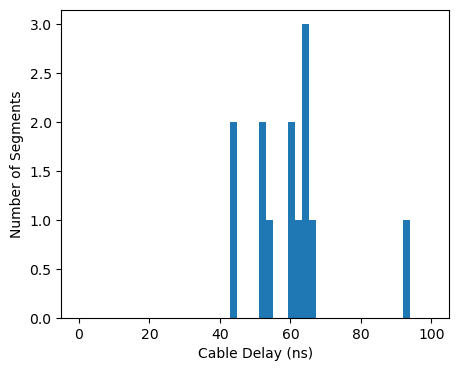

In [19]:
#measure cable delay
delays = measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=True) 
# delay_region_start,delay_region_stop are outputs from figuring out the frequency range from previous function 

print(f'delay: {np.median(delays)}')

In [20]:
len(delays)

17

Looking at ```measure_delay_test_given_freq```: 

In [21]:
# test_sweeps object for this function is usually the initial_lo_sweep data 
# fmin, fmax define the frequency range for measuring the delay, for this point in the 
# full_demod_process function, the inputs are delay_region_start,delay_region_stop, outputs from the previous function 

# if i give you a frequency span, measure the delay 

def measure_delay_test_given_freq(test_sweeps,fmin,fmax,plot=False):
    """
    Manually enter frequency region for cable delay measurement.
    First 100 points currently used because of system stability issue. Might remove in the future if it gets better.
    """
    delays=[] # empty delay list
    for i in range(test_sweeps.shape[1]): # length = number of channels 
        test_sweep=test_sweeps[:,i,:] # takes each channel in sweep as i, then each item in test_sweep is two values? 
        freq_start=np.min(test_sweep[0,:].real) # freq start with range 
        freq_stop=np.max(test_sweep[0,:].real) # freq stop with range
        if freq_start>fmin and freq_stop<fmax: # makes sure it's within bounds 
            # polyfit takes x, y values
            # x = first 100 frequency points, takes real-valued frequency from first block
            # y = phase value using the complex value in second block
            # fits polynomial, extracts coefficient as m
            m,b = np.polyfit(test_sweep[0,:100].real, [cmath.phase(x) for x in test_sweep[1,:100]], 1)
            # slope m corresponds to change in phase with respect to frequency
            # tau takes the phase info and converts to a time delay
            tau=-m/(2*np.pi)
            delays.append(tau)
    delays=np.array(delays)
    delays_sel=delays[np.where(delays>0)] # filters for zero delays
    if plot==True: # plot delay distribution
        #plt.figure(figsize=(11,8))
        plt.figure(figsize=(5,4))
        plt.hist(delays_sel*1e9,bins=np.linspace(0,100,50))
        plt.xlabel('Cable Delay (ns)')
        plt.ylabel('Number of Segments')
    return delays_sel # returns the selected delay array



- why with freq_start and freq_stop are you taking minimum and redefining if you already have the range set by the previous function? 
    - okay so what do fmin and fmax have to be so that this works properly? given the delay_region_start and stop outputs from previous... 
- for the polynomial, you're getting the slope for the fit of the phase... why only first degree fit? 
- need to look at math
- check in about the 100 points ?? 
**Output** = ```delays_sel``` array of the time delays
- do the delays have info encoded about their frequency counterpart ?? 
- why for the one I tried are there 17 points? 
    - oh. i think it's just so he can see the distribution but that's not what he actually uses in the delay removal... 

3. Remove Delays
- dependent on ```remove_delay``` and ```remove_delay_timestream``` functions

In [22]:
# REMOVE DELAY FUNCTION

def remove_delay(target_sweeps,delay,channels='all',start_channel=0,stop_channel=1000):
    target_sweeps_rm=target_sweeps.copy()
    
    # defining loop ranges
    if channels == 'all':
        loop_range = range(target_sweeps.shape[1]) 
    elif channels == 'some':
        loop_range = range(stop_channel-start_channel)
    
    # removing the delays
    for i in loop_range:
        target_sweep=target_sweeps[:,i,:] # going for each channel where there's a tone
        freqs=target_sweep[0,:] # first block, full 500 MHz bandwidth 
        delay_fac=np.exp(1j*delay*2*np.pi*freqs) # delay factor applied to each of MHz bandwidth (?)
        target_sweeps_rm[1,i,:]=target_sweeps[1,i,:]*delay_fac # for each channel of the second block, multiply array by the delay factor (element wise)
            
    return target_sweeps_rm, delay_fac 

getting rid of cable delay ON targeted sweep 

In [27]:
targeted_lo_sweep_rm.shape

targeted_lo_sweep[0,0,:]

array([4.04430371e+09+0.j, 4.04430471e+09+0.j, 4.04430571e+09+0.j,
       4.04430671e+09+0.j, 4.04430771e+09+0.j, 4.04430871e+09+0.j,
       4.04430971e+09+0.j, 4.04431071e+09+0.j, 4.04431171e+09+0.j,
       4.04431271e+09+0.j, 4.04431371e+09+0.j, 4.04431471e+09+0.j,
       4.04431571e+09+0.j, 4.04431671e+09+0.j, 4.04431771e+09+0.j,
       4.04431871e+09+0.j, 4.04431971e+09+0.j, 4.04432071e+09+0.j,
       4.04432171e+09+0.j, 4.04432271e+09+0.j, 4.04432371e+09+0.j,
       4.04432471e+09+0.j, 4.04432571e+09+0.j, 4.04432671e+09+0.j,
       4.04432771e+09+0.j, 4.04432871e+09+0.j, 4.04432971e+09+0.j,
       4.04433071e+09+0.j, 4.04433171e+09+0.j, 4.04433271e+09+0.j,
       4.04433371e+09+0.j, 4.04433471e+09+0.j, 4.04433571e+09+0.j,
       4.04433671e+09+0.j, 4.04433771e+09+0.j, 4.04433871e+09+0.j,
       4.04433971e+09+0.j, 4.04434071e+09+0.j, 4.04434171e+09+0.j,
       4.04434271e+09+0.j, 4.04434371e+09+0.j, 4.04434471e+09+0.j,
       4.04434571e+09+0.j, 4.04434671e+09+0.j, 4.04434771e+09+

- if there are multiple targeted sweeps, which one is used here in the ```remove_delay()``` function? 
- okay back to being confused a bit about the channel/tones
    - there's a 500 MHz band applied for the whole detector system
    - initial sweep has shape (2, 1000, 500)
    - the targeted sweep has different shape, for example (2, 231, 500), dependent on which resonators are actually working (?)
    - but now in the context of the time delay removal: 
        - the full 500 MHz band still applied, and whole thing is corrected. But there aren't 500 resonators working...? 

**ALSO:** why use the initial sweep for the delay? 

**Trying out remove_delay function:**

In [28]:
#remove cable delay
targeted_lo_sweep_rm, delay_factor_example =remove_delay(targeted_lo_sweep,
                                    np.median(delays),
                                    channels=channels,
                                    start_channel=start_channel,
                                    stop_channel=stop_channel)

In [29]:
len(targeted_lo_sweep[1])

231

In [30]:
np.arange(0, len(targeted_lo_sweep[1]), 1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [31]:
targeted_lo_sweep.shape[1]

231

In [32]:
targeted_lo_sweep[1,0,0:231]

array([-2200.5+3344.5j, -2196. +3352.j , -2194. +3352.5j, -2195. +3358.j ,
       -2192. +3357.5j, -2189. +3363.5j, -2183. +3353.5j, -2183. +3364.5j,
       -2173.5+3360.j , -2174. +3368.j , -2170.5+3354.j , -2172. +3366.j ,
       -2161.5+3360.5j, -2157. +3355.5j, -2157.5+3371.j , -2157. +3373.j ,
       -2148. +3354.j , -2141. +3350.5j, -2144.5+3360.j , -2137.5+3361.j ,
       -2133. +3368.j , -2131. +3358.j , -2124.5+3365.j , -2125. +3369.j ,
       -2118.5+3367.j , -2116.5+3361.j , -2113. +3369.j , -2108. +3366.j ,
       -2110. +3371.5j, -2101.5+3371.j , -2099.5+3362.5j, -2095.5+3360.5j,
       -2094.5+3367.j , -2090.5+3367.j , -2084. +3376.j , -2080. +3359.j ,
       -2074. +3357.j , -2076. +3369.j , -2068.5+3356.j , -2067.5+3368.5j,
       -2063.5+3363.j , -2054. +3359.5j, -2056.5+3373.j , -2053. +3368.j ,
       -2046. +3364.5j, -2047.5+3373.5j, -2038.5+3374.j , -2036. +3364.5j,
       -2035. +3380.5j, -2028.5+3367.5j, -2020. +3365.j , -2018.5+3362.j ,
       -2013.5+3370.5j, -

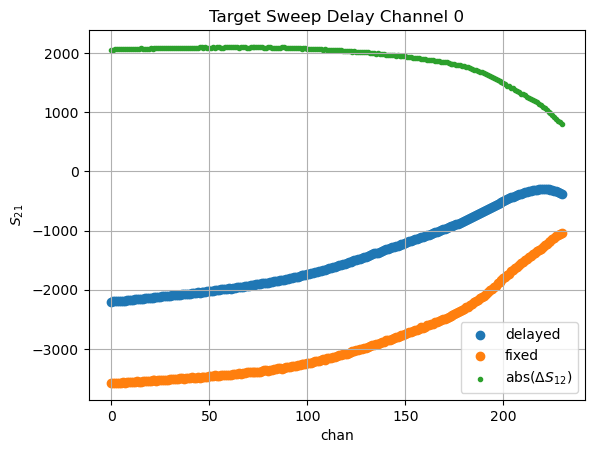

In [36]:
plt.scatter(np.arange(0, len(targeted_lo_sweep[1]), 1), (targeted_lo_sweep[1,0,0:231].real + 1j*targeted_lo_sweep[1,0,0:231].imag), 
            label='delayed')
plt.scatter(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), (targeted_lo_sweep_rm[1,0,0:231].real + 1j*targeted_lo_sweep_rm[1,0,0:231].imag), 
            label='fixed')
plt.scatter(np.arange(0, len(targeted_lo_sweep_rm[1]), 1), np.abs(((targeted_lo_sweep_rm[1,0,0:231].real + 1j*targeted_lo_sweep_rm[1,0,0:231].imag) 
                                                            - (targeted_lo_sweep[1,0,0:231].real + 1j*targeted_lo_sweep[1,0,0:231].imag))), 
                                                            label = r'abs($\Delta S_{12}$)', marker='.')
plt.grid(True)
plt.xlabel('chan')
plt.ylabel(r'$S_{21}$')
plt.title('Target Sweep Delay Channel 0')
plt.legend()
#plt.scatter(targeted_lo_sweep_rm[1,:,:], label = 'fixed')

### Q
- why is it that as you go up in frequency channel, the delay size gets smaller? 

okay questions re: LO sweeps

In [33]:
print('initial LO sweep dimensions:' + str(initial_lo_sweep.shape))
print('targeted LO sweep dimensions:' + str(targeted_lo_sweep.shape))
print('target sweeps delay removed dimensions' + str(targeted_lo_sweep_rm.shape))


initial LO sweep dimensions:(2, 1000, 500)
targeted LO sweep dimensions:(2, 231, 500)
target sweeps delay removed dimensions(2, 231, 500)


In [40]:
print('targeted LO sweep shape' + str(targeted_lo_sweep.shape))
print('First Block')
print(targeted_lo_sweep[0])
first_block_imag = targeted_lo_sweep[0].imag
#plt.plot(first_block_imag)
print('Second Block:')
targeted_lo_sweep[1]

# plt.figure()
# plt.plot(targeted_lo_sweep[0,0:231,10], np.abs((targeted_lo_sweep[0,:,:].real)**2), label='block0 real')
# plt.plot(np.abs((targeted_lo_sweep[0,:,:].imag)**2), label='block0 imag')
# # plt.plot(targeted_lo_sweep[1,100,:].real, label='block1 real')
# # plt.plot(targeted_lo_sweep[1,100,:].imag, label='block1 imag')
# plt.legend()

targeted LO sweep shape(2, 231, 500)
First Block
[[4.04430371e+09+0.j 4.04430471e+09+0.j 4.04430571e+09+0.j ...
  4.04480071e+09+0.j 4.04480171e+09+0.j 4.04480271e+09+0.j]
 [4.04899121e+09+0.j 4.04899221e+09+0.j 4.04899321e+09+0.j ...
  4.04948821e+09+0.j 4.04948921e+09+0.j 4.04949021e+09+0.j]
 [4.05093555e+09+0.j 4.05093655e+09+0.j 4.05093755e+09+0.j ...
  4.05143255e+09+0.j 4.05143355e+09+0.j 4.05143455e+09+0.j]
 ...
 [4.48786914e+09+0.j 4.48787014e+09+0.j 4.48787114e+09+0.j ...
  4.48836614e+09+0.j 4.48836714e+09+0.j 4.48836814e+09+0.j]
 [4.48999512e+09+0.j 4.48999612e+09+0.j 4.48999712e+09+0.j ...
  4.49049212e+09+0.j 4.49049312e+09+0.j 4.49049412e+09+0.j]
 [4.49510840e+09+0.j 4.49510940e+09+0.j 4.49511040e+09+0.j ...
  4.49560540e+09+0.j 4.49560640e+09+0.j 4.49560740e+09+0.j]]
Second Block:


array([[-2200.5+3344.5j, -2196. +3352.j , -2194. +3352.5j, ...,
        -3044.5+3158.5j, -3045.5+3169.j , -3042.5+3164.5j],
       [-1575.5+3780.5j, -1572. +3778.j , -1571. +3783.j , ...,
        -2338. +3494.j , -2340.5+3507.j , -2338. +3508.j ],
       [-1304.5+4120.5j, -1299.5+4124.j , -1293.5+4131.j , ...,
        -1825. +3777.j , -1825.5+3788.j , -1821.5+3782.5j],
       ...,
       [-2017.5 +892.j , -2021.  +893.j , -2019.  +894.5j, ...,
        -2273.5+1019.5j, -2279.5+1026.j , -2272.5+1023.5j],
       [-1138. +1086.5j, -1141.5+1088.5j, -1142.5+1089.j , ...,
        -1303. +1319.j , -1305. +1323.j , -1299.5+1319.j ],
       [ -163. -1910.j ,  -164. -1908.5j,  -161. -1909.5j, ...,
          -30. -1946.j ,   -25.5-1951.j ,   -29.5-1950.5j]])

**removing delay timestream**
- removing delay from the timestream 
- dependent on f0s, which in this case are the frequencies from the list made during the initialization(?) 
    - is the the freqs list from initial or targeted? 

Docstring:
zeros(shape, dtype=float, order='C', *, like=None)

Return a new array of given shape and type, filled with zeros.

Parameters
----------
shape : int or tuple of ints
    Shape of the new array, e.g., ``(2, 3)`` or ``2``.
dtype : data-type, optional
    The desired data-type for the array, e.g., `numpy.int8`.  Default is
    `numpy.float64`.
order : {'C', 'F'}, optional, default: 'C'
    Whether to store multi-dimensional data in row-major
    (C-style) or column-major (Fortran-style) order in
    memory.
like : array_like, optional
    Reference object to allow the creation of arrays which are not
    NumPy arrays. If an array-like passed in as ``like`` supports
    the ``__array_function__`` protocol, the result will be defined
    by it. In this case, it ensures the creation of an array object
    compatible with that passed in via this argument.

    .. versionadded:: 1.20.0

Returns
-------
out : ndarray
    Array of zeros with the given shape, dtype, and order.

See Al

In [107]:
# removing delay timestream function

def remove_delay_timestream(stream,f0s,delay):
    stream_rm=np.zeros((f0s.shape[0],stream.shape[1]),dtype = 'complex_') # make zeros array with shape of (tone_freqs, shape of second timestream data block)
    for i in range(f0s.shape[0]):
        #print(delay)
        #print(f0s)
        delay_fac=np.exp(1j*2*np.pi*f0s[i]*delay)
        #print(delay_fac)
        stream_rm[i,:]=stream[i]*delay_fac
    return stream_rm

# need to know frequency of tone you're dealing with for each i 
# each tone is modulating data at each frequency 

- removing the delay from the timestream, multiplying the complex delay factor by the entire complex stream data -- how does that work? 
- actually just why are we multiplying that I do not follow the math
- Google: "To remove delay from a complex signal, you typically need to apply a phase shift in the frequency domain, which is achieved by multiplying the signal's Fourier Transform by a complex exponential with a negative phase corresponding to the desired delay, essentially "shifting" the signal back in time; this process is often referred to as "phase correction" or "delay compensation" in signal processing"
    - "negative phase" = j ? 
    - Also the Fourier transform is not happening yet so how can we just be multiplying it directly to the I + Qj signal??? 
        - So the f0s are what's being passed in the exponential of the delay factor, which is the frequency tones that are being applied with each data stream
        - so essentially this is just correcting the time information by using a phase shift factor on the values in the time stream. 
        - rather than correcting times 
    - so to create the delay factor, you exponentiate this complex phase multiplied by the time delay multiplied by each of the 231 tones that are actually responding in the resonators
    - THEN for each of the 231 resonators' time stream data, you multiply the complex I + jQ info BY the delay factor, and that becomes the phase-corrected first element of the 2D stream_rm array.

In [105]:
stream = Is_fr+1j*Qs_fr
print(tone_freqs.shape[0])
print(stream.shape[1])

231
4880


In [108]:
#remove cable delay
targeted_lo_sweep_rm=remove_delay(targeted_lo_sweep,
                                    np.median(delays),
                                    channels=channels,
                                    start_channel=start_channel,
                                    stop_channel=stop_channel)

IQ_stream_rm=remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,np.median(delays))

In [139]:
IQ_stream_rm.shape

(231, 4880)

In [114]:
print([targeted_lo_sweep_rm[0].shape], [targeted_lo_sweep_rm[1].shape])

[(2, 231, 500)] [(500,)]


### ?

4. Get calibration

In [ ]:
#measure circle parameters
calibration=measure_circle_allch(targeted_lo_sweep_rm,
                                    tone_freqs,
                                    channels=channels,
                                    start_channel=start_channel,
                                    stop_channel=stop_channel) #finds circle center and initial phase for every channel

print(calibration[0])
#calibrate time stream
data_cal=get_phase(IQ_stream_rm,calibration)

Dependent on ```measure_circle_allch()```, dependent on ```measure_circle()``` (which is dependent on ```calculate_M```), and then ```get_phase()```

In [142]:
def measure_circle(target_sweep,f0):
    """ Finds the resonator circle's center

    Args:
        target_sweep: target S21 sweep around one resonator, col0 is freq, col1 is complex S21
        tau: cable delay in s

    Returns:
        center and radius on the complex plane, and initial phase
    """
    M=calculate_M(target_sweep)
    B = np.array([[0,0,0,-2],[0,1,0,0],[0,0,1,0],[-2,0,0,0]])
    VX=scipy.linalg.eig(M, B)
    X=VX[0]
    V=VX[1]
    C=np.sort(X,0)
    IX=np.argsort(X,0)
    Values = V[:,IX[1]]
    xc = -Values[1]/(2*Values[0])
    yc = -Values[2]/(2*Values[0])
    R = (xc**2+yc**2-Values[3]/Values[0])**0.5
    ind=find_nearest_idx(target_sweep[0,:], f0)
    phi_0=cmath.phase(target_sweep[1,ind]-xc-1j*yc)
    return np.array([xc+1j*yc,R,phi_0])  

#functions for resonator circle fitting

def calculate_M(target_sweep_one):
    I=target_sweep_one[1,:].real
    Q=target_sweep_one[1,:].imag
    z=I**2+Q**2
    
    M=np.zeros((4,4))
    M[0,0]=np.sum(z**2.)
    M[1,1]=np.sum(I**2.)
    M[2,2]=np.sum(Q**2.)
    M[3,3]=I.shape[0]

    M[0,1]=np.sum(I*z)
    M[1,0]=np.sum(I*z)
    M[0,2]=np.sum(Q*z)
    M[2,0]=np.sum(Q*z)

    M[0,3]=np.sum(z)
    M[3,0]=np.sum(z)
    M[1,2]=np.sum(I*Q)
    M[2,1]=np.sum(I*Q)

    M[1,3]=np.sum(I)
    M[3,1]=np.sum(I)
    M[2,3]=np.sum(Q)
    M[3,2]=np.sum(Q)

    return M


- s21 is like what comes out vs what comes in 
- when you put in decibel = 0 
    - with respect to what came in, how many factors of difference is what came out (so factors vs actual ratio)
    - if it's completely absorbed, then would have higher s21 value 
- so if it's 10 decibels up, 10x .... 20 decibels 100x higher 
- 3 dB ~ 2x 
- when you interact with resonator, you're rotating the phase 

using complex numbers: 
- for all your points, you get a circle 
- if you limited the I and Q values to one resonator, you should get a circle
    - but you have loss in the cable 
    - and phase delay in the cable 
    - but we want it 

In [ ]:
s21 is like what comes out vs what comes in 

In [169]:
tone_freqs.shape

(231,)

In [148]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [172]:
measure_circle(targeted_lo_sweep[0,:,0:231], tone_freqs[0:231])

array([4.04910622e+09+0.j, 6.66833780e+04+0.j, 3.14159265e+00+0.j])

len(calculate_M(targeted_lo_sweep_rm))

In [168]:
targeted_lo_sweep.shape

(2, 231, 500)

In [ ]:


def measure_circle_allch(target_sweeps,f0s,channels='all',start_channel=0,stop_channel=1000):
    cals=[]
    
    if channels == 'all':
        loop_range = range(target_sweeps.shape[1])
    elif channels == 'some':
        loop_range = range(stop_channel - start_channel)
    
    for i in loop_range:
        sweep=target_sweeps[:,i,:]
        cal=measure_circle(sweep,f0s[i])
        cals.append(cal)
            
    cals=np.vstack(cals)

    print(f'shape_cals: {cals.shape}')
    return cals  


def get_phase(timestreams,calibration):
    """ Finds the resonator circle's center
    
    Args:
        timestream : timestream data in I and Q for all resonators
        phi_init: initial phase at f0
        calibration: col0 center, col1 radius, col2 initial phase

    Returns:
        phase of timestream in radian
    """
    phases=[]
    for i in range(calibration.shape[0]):
        timestream=timestreams[i]
        center = calibration[i,0]
        phi_init=calibration[i,2]
        timestream_origin=timestream-center
        timestream_rot=timestream_origin*np.exp(-1j*phi_init)
        phase=[cmath.phase(x) for x in timestream_rot]
        #phase-=phi_init
        phase=np.array(phase)
        phases.append(np.unwrap(phase.real))
    phases=np.vstack(phases)
    
    return phases

In [ ]:
print(calibration[0])
    #calibrate time stream
    data_cal=get_phase(IQ_stream_rm,calibration)

the iinformation at end of the day is how you are rotated around the circle 
- we're looking for resonator moving 
- if the resonator has shifted up in freq going up around circle, vise versa 
- oh so you look at the phase, you can see if the resonator move 

whole point of demodulation: 
- for each flux ramp period, one point 
    - there's a sinusoid, what is phase of that , that's the data point 
- if you are doing it corectly, there's series of low phases, then high phases, 



THEN: (LOOK AT DRAWINGS)
need to know how many periods in one flux ramp
- because per flux ramp you're gonna get 

- depending on how high you let the current go, you get a certain number of periods within one flux ramp is 3
- typical wisdom is to use 3-4 periods (called n_phi0s)
    - SQUIDS perform best this way 
    - then we know we want to be modulation in the KHz regime, so we usually will set the flux ramp between 1-10 KHz, then you multiply n_phi0 x frequency of flux ramp = effective modulation for the flux ramp, the effective rate at which we're modulation 
    - been around 15 Hz -- back at 45 hz 
    - why doing this? because of noise 
- so what is the number of flux quanta (SQUID)?? 

Noise: 


for the FFT, they started interpolating between the 32 points

In [ ]:
#find nphi_0
t_start=0
t_stop=10

n_phi0 = find_n_phi0(ts_fr[488*t_start:488*t_stop],data_cal[:,488*t_start:488*t_stop],f_sawtooth,plot=False)  #discard the first few seconds
print(f'n_phi0: {n_phi0}')

#find t0
t0_array = np.array([])
for current_channel in range(len(data_cal)):
    t0 = mea_reset_t0(ts_fr[488*t_start:488*t_stop],data_cal[current_channel,488*t_start:488*t_stop],f_sawtooth,plot=False)
    #ts_freq = 1/np.nanmedian(np.diff(ts_fr))
    #t0 = mea_reset_t0(ts_fr[ts_freq*t_start:ts_freq*t_stop],data_cal[current_channel,ts_freq*t_start:ts_freq*t_stop],f_sawtooth,plot=False)
    t0_array = np.append(t0_array,t0)

t0_med = np.nanmedian(t0_array)

goes through every channel, tries to estimate where flux ramp period started, finding what data point the flux ramp period started 
- the upgrade fixes this

notice: the n_phi0 thing is an 


'iv' method -- just for IV stuff, 

In [ ]:
the noise: 
- the chopper in the FTS is modulating up the light signal 
- 

final output: 
- for each flux ramp, do the demodulation and get a phase value 
- ultimately, the actual phase value is the light 

